# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split 
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [15]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)


sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
'''sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)
'''
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
from bs4 import BeautifulSoup

In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_0)
print(sent_1500)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs loves this chicken but its a product from China so we wont be buying it anymore Its very hard to find any chicken products made in the USA but they are out there but this one isnt Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports 


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:24<00:00, 3645.99it/s]


In [27]:
final['CleanedText']=preprocessed_reviews

In [28]:
sort_final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = sort_final['CleanedText'].values
y = sort_final['Score']

# Finding all words in the vocabulary
count_vect = CountVectorizer() 
count_vect.fit(x)

vocabulary = count_vect.get_feature_names()
print('Total Number of words in the Vocabulary : ',len(vocabulary))

Total Number of words in the Vocabulary :  54904


In [40]:
from keras.preprocessing import sequence

Using TensorFlow backend.


In [29]:
total_corpus = dict()
ind = 0
for sent in x:
    for word in sent.split():
        total_corpus.setdefault(word,[])
        total_corpus[word].append(ind)
        ind += 1

# Getting frequency for each word of vocabulary and storing it in a list
freq = []
for w in vocabulary:
    freq.append(len(total_corpus[w]))

In [30]:
inc_index =np.argsort(np.array(freq))[::-1]

# Allocating ranks to words of vocabulary in decreasing order of frequency and storing words in a dictionary
word_rank = dict()
rank = 1
for i in inc_index:
    word_rank[vocabulary[i]] = rank
    rank +=1

In [31]:
final_data = []
for sent in x:
    row = []
    for word in sent.split():
        if(len(word)>1):
            row.append(word_rank[word])
    final_data.append(row)

In [32]:
X=final_data

In [33]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

## [4.1] 1 Layer LSTM

In [34]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [41]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(61441, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [42]:
max_review_length = 150
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(61441, 150)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  430  505
   10   98    1 1449 3684  689 1184  438    8  709]


In [ ]:
y_test.shape

###### Seems extremly Sparse Layer when using max length greater than 100

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
# fix random seed for reproducibility
np.random.seed(7)


In [1]:
batch_size = 128 
nb_epoch = 12

In [46]:
X_test.shape

(26332, 150)

In [47]:
embedding_vecor_length = 32
model_1 = Sequential()
model_1.add(Embedding(len(vocabulary)+1, embedding_vecor_length, input_length=max_review_length))
model_1.add(Dropout(0.2))
model_1.add(LSTM(100))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 32)           1756960   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,810,261
Trainable params: 1,810,261
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=512 ,verbose=1,validation_data=(X_test, y_test))

Train on 61441 samples, validate on 26332 samples
Epoch 1/12
61441/61441 [==============================] - 72s 1ms/step - loss: 0.3946 - acc: 0.8487 - val_loss: 0.2791 - val_acc: 0.8864
Epoch 2/12
61441/61441 [==============================] - 75s 1ms/step - loss: 0.2071 - acc: 0.9167 - val_loss: 0.2014 - val_acc: 0.9214
Epoch 3/12
61441/61441 [==============================] - 75s 1ms/step - loss: 0.1563 - acc: 0.9402 - val_loss: 0.2047 - val_acc: 0.9204
Epoch 4/12
61441/61441 [==============================] - 75s 1ms/step - loss: 0.1311 - acc: 0.9513 - val_loss: 0.2132 - val_acc: 0.9190
Epoch 5/12
61441/61441 [==============================] - 76s 1ms/step - loss: 0.1146 - acc: 0.9588 - val_loss: 0.2721 - val_acc: 0.9188
Epoch 6/12
61441/61441 [==============================] - 76s 1ms/step - loss: 0.1022 - acc: 0.9635 - val_loss: 0.2412 - val_acc: 0.9065
Epoch 7/12
61441/61441 [==============================] - 76s 1ms/step - loss: 0.1670 - acc: 0.9321 - val_loss: 0.2445 - val_acc

Test score: 0.354357747052085
Test accuracy: 0.9080586358802978


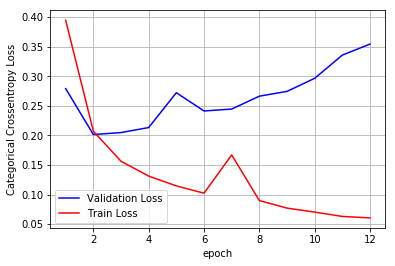

In [49]:

score = model_1.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,nb_epoch+1))


vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

In [64]:
model_1_train_acc = max(history_1.history['acc'])
model_1_test_acc =score[1]

In [65]:
model_1_train_acc

0.9800947250207516

In [66]:
model_1_test_acc

0.9017924957954103

LSTM with 2 Layers

In [50]:
embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(len(vocabulary)+1, embedding_vecor_length, input_length=max_review_length))
model_2.add(LSTM(100,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model_2.add(LSTM(200, dropout=0.4, recurrent_dropout=0.3))
model_2.add(Dense(1, activation='sigmoid'))
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 32)           1756960   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,051,161
Trainable params: 2,051,161
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=batch_size ,verbose=1,validation_data=(X_test, y_test))

Train on 61441 samples, validate on 26332 samples
Epoch 1/12
61441/61441 [==============================] - 351s 6ms/step - loss: 0.2780 - acc: 0.8903 - val_loss: 0.2126 - val_acc: 0.9196
Epoch 2/12
61441/61441 [==============================] - 353s 6ms/step - loss: 0.1849 - acc: 0.9287 - val_loss: 0.2030 - val_acc: 0.9191
Epoch 3/12
61441/61441 [==============================] - 355s 6ms/step - loss: 0.1557 - acc: 0.9407 - val_loss: 0.2082 - val_acc: 0.9214
Epoch 4/12
61441/61441 [==============================] - 355s 6ms/step - loss: 0.1353 - acc: 0.9500 - val_loss: 0.2206 - val_acc: 0.9172
Epoch 5/12
61441/61441 [==============================] - 353s 6ms/step - loss: 0.1197 - acc: 0.9567 - val_loss: 0.2284 - val_acc: 0.9163
Epoch 6/12
61441/61441 [==============================] - 351s 6ms/step - loss: 0.1064 - acc: 0.9625 - val_loss: 0.2436 - val_acc: 0.9152
Epoch 7/12
61441/61441 [==============================] - 359s 6ms/step - loss: 0.0948 - acc: 0.9655 - val_loss: 0.2652 - 

Test score: 0.3012146021563576
Test accuracy: 0.9093498404710901


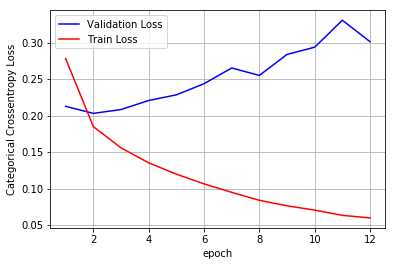

In [52]:
score = model_2.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,nb_epoch+1))


vy = history_2.history['val_loss']
ty = history_2.history['loss']
plt_dynamic(x, vy, ty, ax)

In [60]:
model_2_train_acc = max(history_2.history['acc'])
model_2_test_acc =score[1]

In [61]:
model_2_test_acc

0.9017924957954103

In [62]:
model_2_train_acc

0.9791995572988721

In [53]:
embedding_vecor_length = 32
model_3 = Sequential()
model_3.add(Embedding(len(vocabulary)+1, embedding_vecor_length, input_length=max_review_length))
model_3.add(LSTM(100,return_sequences=True, dropout=0.3, recurrent_dropout=0.4))
model_3.add(LSTM(200,return_sequences=True, dropout=0.4, recurrent_dropout=0.3))
model_3.add(LSTM(300,dropout=0.5, recurrent_dropout=0.3))
model_3.add(Dense(1, activation='sigmoid'))
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 32)           1756960   
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 150, 200)          240800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 300)               601200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 2,652,461
Trainable params: 2,652,461
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=batch_size ,verbose=1,validation_data=(X_test, y_test))

Train on 61441 samples, validate on 26332 samples
Epoch 1/12
61441/61441 [==============================] - 851s 14ms/step - loss: 0.2817 - acc: 0.8881 - val_loss: 0.2170 - val_acc: 0.9147
Epoch 2/12
61441/61441 [==============================] - 851s 14ms/step - loss: 0.1832 - acc: 0.9285 - val_loss: 0.2219 - val_acc: 0.9195
Epoch 3/12
61441/61441 [==============================] - 857s 14ms/step - loss: 0.1766 - acc: 0.9316 - val_loss: 0.2362 - val_acc: 0.9186
Epoch 4/12
61441/61441 [==============================] - 855s 14ms/step - loss: 0.1368 - acc: 0.9483 - val_loss: 0.2136 - val_acc: 0.9180
Epoch 5/12
61441/61441 [==============================] - 845s 14ms/step - loss: 0.1159 - acc: 0.9580 - val_loss: 0.2457 - val_acc: 0.9084
Epoch 6/12
61441/61441 [==============================] - 845s 14ms/step - loss: 0.1048 - acc: 0.9626 - val_loss: 0.2625 - val_acc: 0.9160
Epoch 7/12
61441/61441 [==============================] - 848s 14ms/step - loss: 0.1051 - acc: 0.9622 - val_loss: 0.

Test score: 0.3489475777670096
Test accuracy: 0.9017924957954103


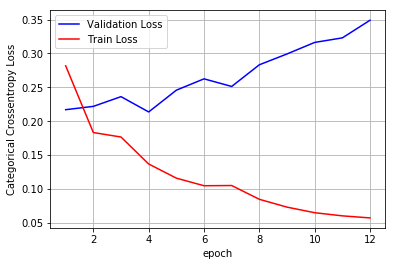

In [55]:
score = model_3.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,nb_epoch+1))


vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)

In [57]:
model_3_train_acc = max(history_3.history['acc'])
model_3_test_acc =score[1]

In [58]:
model_3_test_acc

0.9017924957954103

In [59]:
model_3_train_acc

0.9805341709933106

# [6] Conclusions

In [56]:
# Please compare all your models using Prettytable library

In [67]:
from prettytable import PrettyTable

In [68]:
x = PrettyTable()
x.field_names =['Model','Training Accuracy  ','Test Accuracy']
x.add_row(["Model 1  ",model_1_train_acc, model_1_test_acc] )

x.add_row(["Model 2 ",model_2_train_acc, model_2_test_acc] )

x.add_row(["Model 3 ",model_3_train_acc, model_3_test_acc] )

print(x)

+-----------+---------------------+--------------------+
|   Model   | Training Accuracy   |   Test Accuracy    |
+-----------+---------------------+--------------------+
| Model 1   |  0.9800947250207516 | 0.9017924957954103 |
|  Model 2  |  0.9791995572988721 | 0.9017924957954103 |
|  Model 3  |  0.9805341709933106 | 0.9017924957954103 |
+-----------+---------------------+--------------------+


###### Steps with Conclusions